# Importing Packages

In [58]:
# Load data
import torch
import torchvision
from torchvision import datasets, models, transforms, utils

# Visualize data
import numpy as np
import matplotlib.pyplot as plt

# Training
from tempfile import TemporaryDirectory
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
from PIL import Image
import time
import os

torch.cuda.empty_cache()
cudnn.benchmark = True
plt.ion()   # interactive mode

# Load Data

In [59]:
# Data augmentation and normalization for training
# Just normalization for validation

data_transform = {
    'train' : transforms.Compose([
        #transforms.Grayscale(num_output_channels=3), 
        transforms.ToTensor(),
        transforms.Normalize([0.5,], [0.5,])
    ]),

    'test' : transforms.Compose([
        #transforms.Grayscale(num_output_channels=3), 
        transforms.ToTensor(),
        transforms.Normalize([0.5,], [0.5,])
    ]),
}

data_dir = '/home/moritz/git/group_mfja_emnist/'

image_datasets = {
    'train': datasets.EMNIST(
        root = data_dir,
        split = 'balanced',
        train = True,
        download = True,
        transform = data_transform['train']
    ),

    'test': datasets.EMNIST(
        root = data_dir,
        split = 'balanced',
        train = False,
        download = True,
        transform = data_transform['test']
    )
}

dataloaders = {
    x: torch.utils.data.DataLoader(image_datasets[x], batch_size=64, shuffle=(x == 'train'))
    for x in ['train', 'test']
}

class_names = image_datasets['train'].classes
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Visualize Data

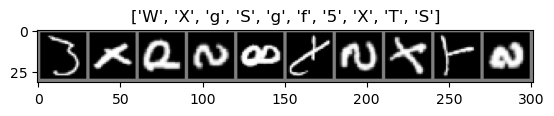

In [76]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.5,])
    std = np.array([0.5,])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs[:10], nrow=10)

imshow(out, title=[class_names[x] for x in classes[:10]])

Training the model
==================

Now, let\'s write a general function to train a model. Here, we will
illustrate:

-   Scheduling the learning rate
-   Saving the best model

In the following, parameter `scheduler` is an LR scheduler object from
`torch.optim.lr_scheduler`.


In [61]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=5):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')
    
        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'test']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'test' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model

Visualizing the model predictions
=================================

Generic function to display predictions for a few images


In [62]:
def visualize_model(model, num_images=10):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Finetuning the ConvNet
======================

Load a pretrained model and reset final fully connected layer.


In [63]:
model_ft = models.resnet50(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
num_classes = len(class_names)
model_ft.fc = nn.Linear(num_ftrs, num_classes)
model_ft.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Train and evaluate
==================

It should take around 15-25 min on CPU. On GPU though, it takes less
than a minute.


In [64]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=5)

Epoch 0/4
----------
train Loss: 0.8334 Acc: 0.7476
test Loss: 0.3911 Acc: 0.8634

Epoch 1/4
----------
train Loss: 0.3726 Acc: 0.8654
test Loss: 0.3501 Acc: 0.8755

Epoch 2/4
----------
train Loss: 0.3085 Acc: 0.8848
test Loss: 0.3389 Acc: 0.8830

Epoch 3/4
----------
train Loss: 0.2691 Acc: 0.8975
test Loss: 0.3283 Acc: 0.8859

Epoch 4/4
----------
train Loss: 0.2469 Acc: 0.9040
test Loss: 0.3278 Acc: 0.8849

Training complete in 3m 51s
Best val Acc: 0.885851


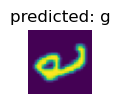

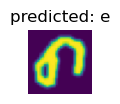

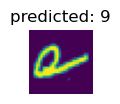

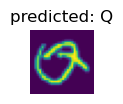

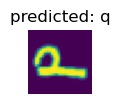

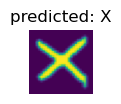

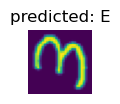

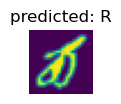

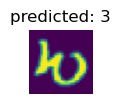

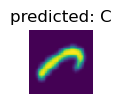

In [65]:
visualize_model(model_ft)

ConvNet as fixed feature extractor
==================================

Here, we need to freeze all the network except the final layer. We need
to set `requires_grad = False` to freeze the parameters so that the
gradients are not computed in `backward()`.

You can read more about this in the documentation
[here](https://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward).


In [77]:
model_conv = torchvision.models.resnet50(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, num_classes)
model_ft.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

Train and evaluate
==================

On CPU this will take about half the time compared to previous scenario.
This is expected as gradients don\'t need to be computed for most of the
network. However, forward does need to be computed.


In [78]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=5)

Epoch 0/4
----------
train Loss: 3.0484 Acc: 0.2404
test Loss: 2.7237 Acc: 0.3122

Epoch 1/4
----------
train Loss: 2.6308 Acc: 0.3229
test Loss: 2.5683 Acc: 0.3397

Epoch 2/4
----------
train Loss: 2.5123 Acc: 0.3459
test Loss: 2.4892 Acc: 0.3586

Epoch 3/4
----------
train Loss: 2.4312 Acc: 0.3617
test Loss: 2.4241 Acc: 0.3662

Epoch 4/4
----------


KeyboardInterrupt: 

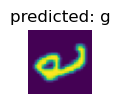

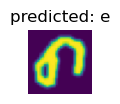

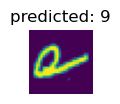

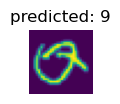

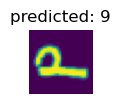

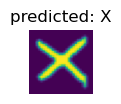

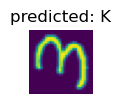

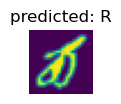

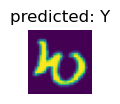

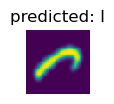

In [70]:
visualize_model(model_conv)

plt.ioff()
plt.show()

Inference on custom images
==========================

Use the trained model to make predictions on custom images and visualize
the predicted class labels along with the images.


In [71]:
def visualize_model_predictions(model,img_path):
    was_training = model.training
    model.eval()

    img = Image.open(img_path)
    img = data_transforms['test'](img)
    img = img.unsqueeze(0)
    img = img.to(device)

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

        ax = plt.subplot(2,2,1)
        ax.axis('off')
        ax.set_title(f'Predicted: {class_names[preds[0]]}')
        imshow(img.cpu().data[0])
        
        model.train(mode=was_training)

In [75]:
visualize_model_predictions(
    model_conv,
    img_path="idk"
)

plt.ioff()
plt.show()

IndexError: too many indices for tensor of dimension 1